In [1]:
import os
import glob
import random
import pandas as pd
import numpy as np

%matplotlib inline  

# Získanie datasetu

In [2]:
# Download dataset
DATASET_URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
DATASET_DIR = 'dataset'
DATASET_FILE_PATH = f'{DATASET_DIR}/aclImdb_v1.tar.gz'

if not os.path.isfile(DATASET_FILE_PATH):
    print(f'Downloading dataset into {DATASET_FILE_PATH} ...')
    with urllib.request.urlopen(DATASET_URL) as response, open(DATASET_FILE_PATH, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
else:
    print('Dataset already downloaded.')

Dataset already downloaded.


In [3]:
# Untar the dataset archive
if not os.path.isdir(f'{DATASET_DIR}/aclImdb'):
    with tarfile.open(DATASET_FILE_PATH) as archive:
        print(f'Extracting "{DATASET_FILE_PATH}" to "{DATASET_DIR}" ...')
        archive.extractall(DATASET_DIR)
        print('Extraction finished.')
else:
    print('Dataset already extracted.')


Dataset already extracted.


In [4]:
# Load data from folders
TEST_FOLDER = f'{DATASET_DIR}/aclImdb/test'
TEST_POSITIVE_FOLDER = f'{TEST_FOLDER}/pos'
TEST_NEGATIVE_FOLDER = f'{TEST_FOLDER}/neg'

TRAIN_FOLDER = f'{DATASET_DIR}/aclImdb/train'
TRAIN_POSITIVE_FOLDER = f'{TRAIN_FOLDER}/pos'
TRAIN_NEGATIVE_FOLDER = f'{TRAIN_FOLDER}/neg'
TRAIN_UNSUPERVISED_FOLDER = f'{TRAIN_FOLDER}/unsup'

VOCAB_SIZE = 1_000_000
MAX_SENTENCE_LEN = 100000

In [5]:
TEST_FOLDER

'dataset/aclImdb/test'

In [6]:
def create_labeled_dataset_from_files(folders, label_map={'pos':[1, 0], 'neg': [0, 1]}, shuffle=True):
    files = map(lambda folder: [glob.glob(f'{folder}/*'), f'{folder}'], folders)

    # Assign label to every files based on folder they are in
    labeled_files = map(lambda files_with_label:
                        map(lambda file_path:
                            [file_path, files_with_label[1].split('/')[-1]] # Take only the last folde from the folder path
                        , files_with_label[0])
                    , files)

    # flatten list
    flat_labeled_files = []
    for lf in labeled_files:
        for fl in lf:
            flat_labeled_files.append(fl)

    if shuffle:
        random.shuffle(flat_labeled_files)

    # read file contents
    labeled_texts = map(lambda example: [open(example[0]).read().split(' ')[:MAX_SENTENCE_LEN], example[1]], flat_labeled_files)

    return labeled_texts

cls_test_ds = create_labeled_dataset_from_files([f'{TEST_POSITIVE_FOLDER}', f'{TEST_NEGATIVE_FOLDER}'])
cls_train_ds = create_labeled_dataset_from_files([f'{TRAIN_POSITIVE_FOLDER}', f'{TRAIN_NEGATIVE_FOLDER}'])

In [7]:
reviews_train = []
for review in list(cls_train_ds):
    reviews_train.append([" ".join(review[0]), review[1]])

reviews_test = []
for review in list(cls_test_ds):
    reviews_test.append([" ".join(review[0]), review[1]])

In [8]:
test_df = pd.DataFrame(np.array(reviews_test), columns=['review_text', 'sentiment'])
train_df = pd.DataFrame(np.array(reviews_train), columns=['review_text', 'sentiment'])

# Trénovací a testovací dataset

Datasety pozostávajú z dvoch atribútov - text recenzie a sentiment. Oba atribúty sú v textovej podobe, čiže je nutné ich upraviť do číselnej podoby.

## Ukážka datasetu train_df

In [9]:
train_df.head()

,review_text,sentiment
0,Von Trier once explained how he created such s...,pos
1,"I love movies, and I'll watch any movie all th...",neg
2,Why has this not been released? I kind of thou...,pos
3,"I wasn't sure how to rate this movie, since it...",neg
4,I saW this film while at Birmingham Southern C...,pos


In [10]:
train_df.describe()

,review_text,sentiment
count,25000,25000
unique,24904,2
top,"When i got this movie free from my job, along ...",neg
freq,3,12500


In [11]:
train_df.dtypes

review_text    object
sentiment      object
dtype: object

In [12]:
train_df['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

## Ukážka datasetu test_df

In [13]:
test_df.head()

,review_text,sentiment
0,"In Moscow, the young couple Veronika (T. Samoj...",pos
1,GEORGE AND MILDRED was a spin off from the mid...,neg
2,h.o.t.s. is one of those sexy 70's drive in mo...,pos
3,Little Vera is the story of a Russian teenager...,pos
4,"The Patriot is a well thought out, well produc...",pos


In [14]:
test_df.describe()

,review_text,sentiment
count,25000,25000
unique,24801,2
top,Loved today's show!!! It was a variety and not...,neg
freq,5,12500


Z nasledujúcích údajov môžeme vidieť, že v datasete sa nachádza 24795 unikátnych recenzií, respektíve 225 duplikátov.

In [15]:
test_df.dtypes

review_text    object
sentiment      object
dtype: object

In [16]:
test_df['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

# Prekryv prvkov z train a test datasetu

In [17]:
overlap = train_df.isin(test_df)

In [18]:
overlap[overlap['review_text'] == True]

,review_text,sentiment


Môžeme vidieť, že v našom datasete sa nenachádzajú žiadne recenzie, ktoré sa nachádzajú v trénovacej aj testovacej množine.

# min, mod, median -> dlzky reviews v pos a neg.


In [19]:
test_df['review_text'].str.len().describe()

count    25000.00000
mean      1293.79240
std        975.90776
min         32.00000
25%        696.00000
50%        962.00000
75%       1572.00000
max      12988.00000
Name: review_text, dtype: float64

In [20]:
train_df['review_text'].str.len().describe()

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: review_text, dtype: float64

In [21]:
import tensorflow as tf
def get_tokenizer(vocab_file, vocab_size, separator='\n'):
    vocab = open(vocab_file).read().split(separator)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, oov_token=vocab_size)
    tokenizer.fit_on_texts(vocab)
    return tokenizer

tokenizer = get_tokenizer(f'{DATASET_DIR}/aclImdb/imdb.vocab', VOCAB_SIZE+1)

['non', 'like', 'the'] [344, 326, 277]


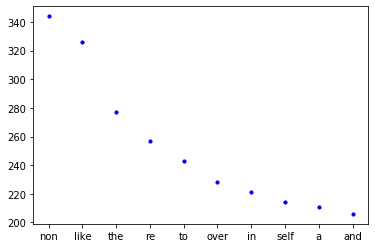

In [77]:
import json
data = json.loads(tokenizer.to_json())
data = json.loads(data["config"]["word_counts"])

words = [key for key, value in data.items()]
counts = [value for key, value in data.items()]

data = list(zip(words, counts))
data = sorted(data, key=lambda d: d[1], reverse=True)

words = [d[0] for d in data]
counts = [d[1] for d in data]

print(words[:3], counts[:3])

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.scatter(
    words[:10],
    counts[:10],
    color="blue",
    s=10
  )

# n, bins, patches = plt.hist(x, facecolor='blue', alpha=0.5, label=['ahoj', 'ahoj'])
plt.show()